In [1]:
# import os
# os.listdir('../input/rl-project')
# import sys
# sys.path.insert(0,'../input/rl-project/')

In [2]:
import torch
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import time
import math
import cv2

from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter
import socket
from datetime import datetime
import os

from agents import Agent
from environment import SimulationEnvironment0
from replay_buffers import *
from utils import *

import copy
experiment_name='discrete_control_PPO_buffers1'

  0%|          | 0/131072 [00:19<?, ?it/s]


KeyboardInterrupt: 

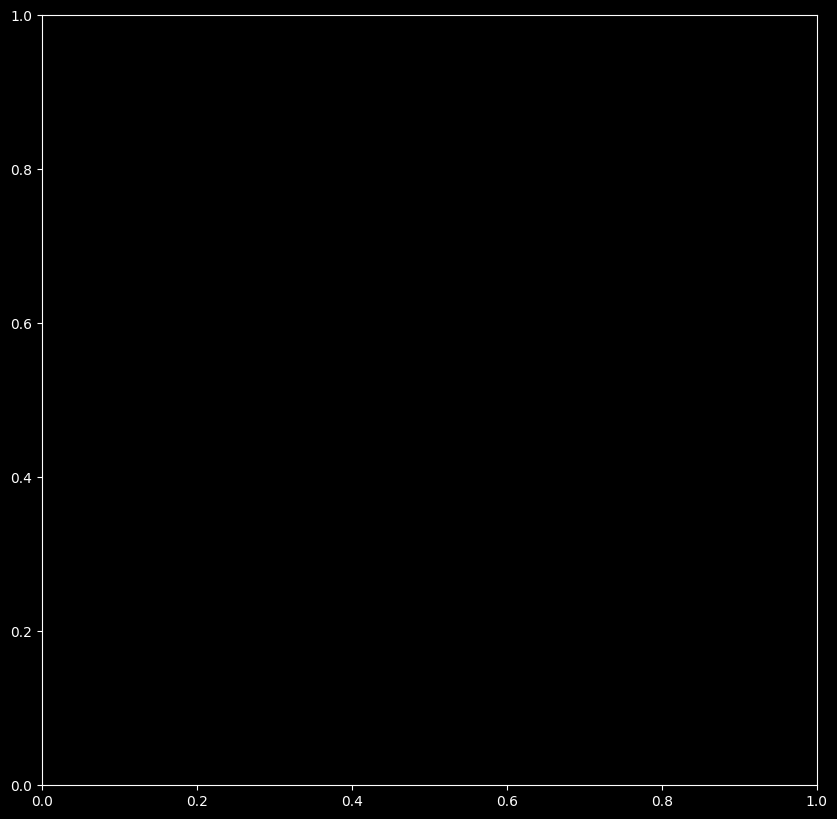

In [4]:
seed = 0

EXPERIMENTS = [#{"entropy": 3e-4, 'epochs':0, 'PPO':1, 'training_steps':2**17, 'size': 2**16},
               #{"entropy": 3e-4, 'epochs':0, 'PPO':2, 'training_steps':2**17, 'size': 2**16},
               #{"entropy": 3e-4, 'epochs':1, 'PPO':1, 'training_steps':2**17, 'size': 2**16},
               #{"entropy": 3e-4, 'epochs':1, 'PPO':2, 'training_steps':2**17, 'size': 2**16},
               #{"entropy": 3e-4, 'epochs':2, 'PPO':1, 'training_steps':2**17, 'size': 2**16},
               #{"entropy": 3e-4, 'epochs':2, 'PPO':2, 'training_steps':2**17, 'size': 2**16},
               #{"entropy": 3e-4, 'epochs':2, 'PPO':2, 'training_steps':2**17, 'size': 2**16},
               #{"entropy": 3e-4, 'epochs':0, 'PPO':4, 'training_steps':2**17, 'size': 2**16},
               #{"entropy": 3e-4, 'epochs':1, 'PPO':4, 'training_steps':2**17, 'size': 2**16},
               #{"entropy": 3e-4, 'epochs':2, 'PPO':4, 'training_steps':2**17, 'size': 2**16},
               {"entropy": 3e-4, 'epochs':0, 'PPO':1, 'training_steps':2**17, 'size': 2**12},
               {"entropy": 3e-4, 'epochs':0, 'PPO':2, 'training_steps':2**17, 'size': 2**12},
               {"entropy": 3e-4, 'epochs':0, 'PPO':4, 'training_steps':2**17, 'size': 2**12},
               {"entropy": 3e-4, 'epochs':1, 'PPO':1, 'training_steps':2**17, 'size': 2**12},
               {"entropy": 3e-4, 'epochs':1, 'PPO':2, 'training_steps':2**17, 'size': 2**12},
               {"entropy": 3e-4, 'epochs':1, 'PPO':4, 'training_steps':2**17, 'size': 2**12},
               {"entropy": 3e-4, 'epochs':2, 'PPO':1, 'training_steps':2**17, 'size': 2**12},
               {"entropy": 3e-4, 'epochs':2, 'PPO':2, 'training_steps':2**17, 'size': 2**12},
               {"entropy": 3e-4, 'epochs':2, 'PPO':4, 'training_steps':2**17, 'size': 2**12},
               ]




# simulation
num_simulations = 128
num_blackholes = 1

# agent
hidden_size = 512
simlog_res = 255
use_symlog = True
simlog_half_res = simlog_res//2
simlog_max_range = 1
actions_res = 5
levels=2
input_type = 'complete'

lr = 3e-4
lr_actor = 3e-5


# training
#training_steps = 2**18
#epochs=8
gamma = 0.98
smoothing = 1e-2
eps = 0.1

batch_size = 2**10

# replay buffers
buffer = Replay_Buffer
#size = 2**16
batch_size = 2**10

plot = False

validate_every = 2**7

bin_values = (torch.arange(simlog_res)-simlog_half_res).cuda()/simlog_half_res*simlog_max_range
bin_values = bin_values.sign()*(bin_values.abs().exp()-1)

dec_x, dec_y = torch.meshgrid(torch.arange(actions_res)/(actions_res-1)*2-1, torch.arange(actions_res)/(actions_res-1)*2-1)
dec_x, dec_y = dec_x.flatten().cuda(), dec_y.flatten().cuda()

metric_idx = torch.pow(2,torch.arange(15))-1

fig, ax = plt.subplots(figsize=(10,10))


for experiment in EXPERIMENTS:

    torch.manual_seed(seed)

    current_time = datetime.now().strftime("%b%d_%H-%M-%S")
    log_dir = os.path.join(
        "runs",experiment_name, current_time + "_" + socket.gethostname() 
    )

    tb_writer = SummaryWriter(log_dir)

    sim = SimulationEnvironment0(num_simulations=128,
                            num_blackholes=num_blackholes, 
                            force_constant=0.002, 
                            velocity_scale=0.01,
                            goal_threshold=0.05,
                            max_steps=250,
                            device='cuda')

    if use_symlog:
        actor = Agent((num_blackholes+2), hidden_size, levels, input_type, critic=False, action_dimension=actions_res**2).cuda()
        critic = Agent((num_blackholes+2), hidden_size, levels, input_type, actor=False, value_dimension=simlog_res).cuda()
    else:
        actor = Agent((num_blackholes+2), hidden_size, levels, input_type, critic=False, action_dimension=actions_res**2).cuda()
        critic = Agent((num_blackholes+2), hidden_size, levels, input_type, actor=False, value_dimension=1).cuda()

    optim_actor = torch.optim.AdamW(actor.parameters(), lr=lr_actor, weight_decay=1e-3)
    optim_critic = torch.optim.AdamW(critic.parameters(), lr=lr, weight_decay=1e-3)
    target_critic = copy.deepcopy(critic)
    
    replay_buffer = buffer(state_shape=((num_blackholes+2),2), action_shape=(1,), batch_size=batch_size, size=experiment['size'], device='cuda')

    old_states=None

    R=[]

    from tqdm import tqdm
    pbar = tqdm(range(experiment['training_steps']))

    x,y = torch.meshgrid(torch.arange(100),torch.arange(100))
    pos = torch.stack([x.flatten(), y.flatten()],1)/100
    target_pos = torch.ones_like(pos)*0.25
    bh_pos = torch.ones_like(pos)*0.75

    st=torch.stack([pos,target_pos,bh_pos],1)

    E = []
    plotV = []
    plotVT = []
    plotPolicy = []

    
    states = sim.get_state()
    for i in pbar:
        t0=time.time()

        # generate experience
        states = states.reshape(states.shape[0],-1).cuda()
        actions, _ = actor(states)
        _, values = critic(states)

        action_probs = actions.softmax(-1)
        dist = Categorical(action_probs)
        sampled_action = dist.sample()
        log_prob = dist.log_prob(sampled_action)

        u, v = dec_x[sampled_action], dec_y[sampled_action]
        sampled_action_decoded = torch.stack([u,v],1)

        rewards, new_states, is_terminal = sim.step(sampled_action_decoded)

        # train the critic
        with torch.inference_mode():
            _, next_values = target_critic(new_states.reshape(new_states.shape[0],-1).cuda())

            if use_symlog:
                expexted_next_value = (torch.softmax(next_values,1)@bin_values[:,None])[:,0]*(is_terminal.logical_not())
            else:
                expexted_next_value = next_values.squeeze(1)*(is_terminal.logical_not())

            expecter_target_value = rewards + gamma*expexted_next_value

        if use_symlog:
            y = two_hot_encode(expecter_target_value, simlog_max_range, simlog_res, simlog_half_res, smoothing=smoothing)
            critic_error = torch.nn.functional.cross_entropy(values, y, reduction='none')
        else:
            critic_error = torch.square(values-expecter_target_value)

        optim_critic.zero_grad()
        critic_error.mean().backward()
        optim_critic.step()

        # train the actor
        expexted_value = (torch.softmax(values,1)@bin_values[:,None])[:,0]
        expected_prediction_error = (expexted_value - expecter_target_value)

        H = -(action_probs*(action_probs+1e-8).log()).sum(-1)
        actor_error = expected_prediction_error.detach() * log_prob - H*experiment['entropy']

        optim_actor.zero_grad()
        actor_error.mean().backward()
        optim_actor.step()


        if isinstance(replay_buffer, Replay_Buffer):
            replay_buffer.add_experience(states=states, actions=sampled_action, action_probs=log_prob, rewards=rewards, next_states=new_states, terminals=is_terminal)
        elif isinstance(replay_buffer, Prioritized_Replay_Buffer):
            replay_buffer.add_experience(states=states, actions=sampled_action, action_probs=log_prob, rewards=rewards, next_states=new_states, terminals=is_terminal, weights=critic_error+1e-7)

        #log
        E.append(critic_error.mean().item())
        R.append(rewards.mean().item())

        tb_writer.add_scalar('TD error', expected_prediction_error.mean().item(), i)
        tb_writer.add_scalar('Actor error', actor_error.mean().item(), i)
        tb_writer.add_scalar('Critic error', critic_error.mean().item(), i)
        tb_writer.add_scalar('Reward',rewards.mean().item(), i)

        # train actor with PPO
        old_probs = log_prob.exp().detach()
        for b_idx in range(experiment['PPO']):

            actions, _ = actor(states)

            action_probs = actions.softmax(-1)
            H = -(action_probs*(action_probs+1e-8).log()).sum(-1)
            dist = Categorical(action_probs)
            log_prob = dist.log_prob(sampled_action)

            r = log_prob.exp()/(old_probs+1e-8)
            objective = expected_prediction_error.detach() * r #inverse, to me minimized
            objective_clipped =  expected_prediction_error.detach() * r.clip(1-eps,1+eps)

            actor_error = torch.maximum(objective,objective_clipped) - H*experiment['entropy']

            optim_actor.zero_grad()
            actor_error.mean().backward()
            optim_actor.step()

        # train critic on old experience
        for b_idx in range(experiment['epochs']):
            b_states, b_actions, b_log_prob, b_rewards, b_next_states, b_terminals, weights = replay_buffer.get_batch()

            _, values = critic(b_states.reshape(b_states.shape[0],-1).cuda())

            with torch.inference_mode():
                _, next_values = target_critic(b_next_states.reshape(b_next_states.shape[0],-1).cuda())

                expexted_next_value = (torch.softmax(next_values,1)@bin_values[:,None])[:,0]*(b_terminals.logical_not())

                expecter_target_value = b_rewards + gamma*expexted_next_value

            y = two_hot_encode(expecter_target_value, simlog_max_range, simlog_res, simlog_half_res, smoothing=smoothing)
            critic_error = (torch.nn.functional.cross_entropy(values, y, reduction='none'))

            expexted_value = (torch.softmax(values,1)@bin_values[:,None])[:,0]
            expected_prediction_error = (expexted_value - expecter_target_value)

            if weights is not None:
                critic_error /= weights

            optim_critic.zero_grad()
            critic_error.mean().backward()
            optim_critic.step()

            if weights is not None:
                replay_buffer.update_weights(critic_error+1e-7)

        update_target_model(model=critic, target_model=target_critic, decay=1e-3)

        states = new_states

        if i % 8 == 0:
            pbar.set_postfix_str(f'{critic_error.mean().item():.3g}'.ljust(10)+
                                 f'{actor_error.mean().item():.3g}'.ljust(10)+
                                f'{rewards.mean().item():.3g}'.ljust(10))


        if (i+1) % validate_every == 0:

            V = []
            A = []
            for b in range((len(st)+batch_size-1)//batch_size):
                stb = st[b*batch_size:(b+1)*batch_size]
                _, v = critic(stb.reshape(stb.shape[0],-1).cuda())
                a, _ = actor(stb.reshape(stb.shape[0],-1).cuda())
                V.append(v)
                A.append(a)
            V = torch.concat(V,0)
            A = torch.concat(A,0)

            V_t = []
            for b in range((len(st)+batch_size-1)//batch_size):
                stb = st[b*batch_size:(b+1)*batch_size]

                _, v = target_critic(stb.reshape(stb.shape[0],-1).cuda())

                V_t.append(v)
            V_t = torch.concat(V_t,0)


            if use_symlog:
                V = (V.softmax(1)@bin_values[:,None])[:,0].detach().cpu()
                V_t = (V_t.softmax(1)@bin_values[:,None])[:,0].detach().cpu()
            else:
                V = V.cpu()
                V_t = V_t.cpu()

            tb_writer.add_image('V', (V.reshape(1,100,100)/2+0.5), i)
            tb_writer.add_image('V_t', V_t.reshape(1,100,100)/2+0.5, i)

            plotV.append(V.reshape(1,100,100).detach().cpu())
            plotVT.append(V_t.reshape(1,100,100).detach().cpu())

            pos = st[:,0].reshape(100,100,-1)[::2,::2]
            A = A.reshape(100,100,-1)[::2,::2]
            # A = A/2
            action_probs = A.softmax(-1)
            u = action_probs@dec_x[:,None]
            v = action_probs@dec_y[:,None]
            A = torch.concat([u,v],-1)

            plt.quiver(pos[...,1].flatten(), -pos[...,0].flatten(), A[...,1].tanh().detach().cpu().flatten(), -A[...,0].tanh().detach().cpu().flatten(), color='g',scale=50, headwidth=2)
            ax.axis('off')
            plt.gca().set_aspect('equal')
            plt.subplots_adjust(0,0,1,1,0,0)
            fig.canvas.draw()
            data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.clf()

            tb_writer.add_image('Policy visualization', np.transpose(data,(2,0,1)) , i)
            plotPolicy.append(np.transpose(data,(2,0,1)))

    # experiment.update({'E':torch.tensor(E), 'plotV':torch.stack(plotV), 'plotVT':torch.stack(plotVT), 'plotPolicy':torch.tensor(plotPolicy)})
    torch.save(experiment,
        os.path.join(log_dir,'results.pth'))


            
